# Implementation of BatchNorm from scratch

In [4]:
%matplotlib inline

In [ ]:
import torch # base library for tensor operations
import torch.nn as nn #pytorch's neural nets module
import matplotlib.pyplot as plt

💬 Explanation:

This mimics PyTorch’s nn.BatchNorm1d but written from scratch.
During train(), we use batch stats to normalize.
During eval(), we use running estimates for stable behavior.
gamma and beta are learnable parameters that allow the model to undo normalization if needed.

In [6]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))  # Learnable scale
        self.beta = nn.Parameter(torch.zeros(num_features))  # Learnable shift
        self.running_mean = torch.zeros(num_features)        # For inference
        self.running_var = torch.ones(num_features)          # For inference

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=0)
            var = x.var(dim=0, unbiased=False)

            # Update running estimates
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
        else:
            mean = self.running_mean
            var = self.running_var

        # Normalize + scale/shift
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * x_hat + self.beta
        return out


💬 Explanation:

We'll feed 50 batches of fake data into our layer to track how the batch stats and running stats evolve.
Each "batch" will simulate training data from one step in an epoch.

In [7]:
# Instantiate our BatchNorm with 1 feature (just for clarity)
bn = BatchNorm(num_features=1)

# Define how many batches we want to simulate
num_batches = 50

# Containers for logging stats
batch_means = []
batch_vars = []
running_means = []
running_vars = []


💬 Explanation:

We generate random inputs that slowly shift in distribution (to mimic learning on non-stationary data).
.train() makes sure the forward pass uses batch stats (not running).
We store both per-batch stats and internal running_* values for visualization.

In [8]:
# Simulate fake data input and forward passes
for i in range(num_batches):
    # Create a batch of 32 samples with 1 feature, shifting the mean slowly
    x = torch.randn(32, 1) * 2 + (i / 10.0)

    bn.train()  # Ensure we are in training mode
    _ = bn(x)   # Forward pass to trigger BN update

    # Log stats
    batch_means.append(x.mean().item())
    batch_vars.append(x.var(unbiased=False).item())
    running_means.append(bn.running_mean.item())
    running_vars.append(bn.running_var.item())


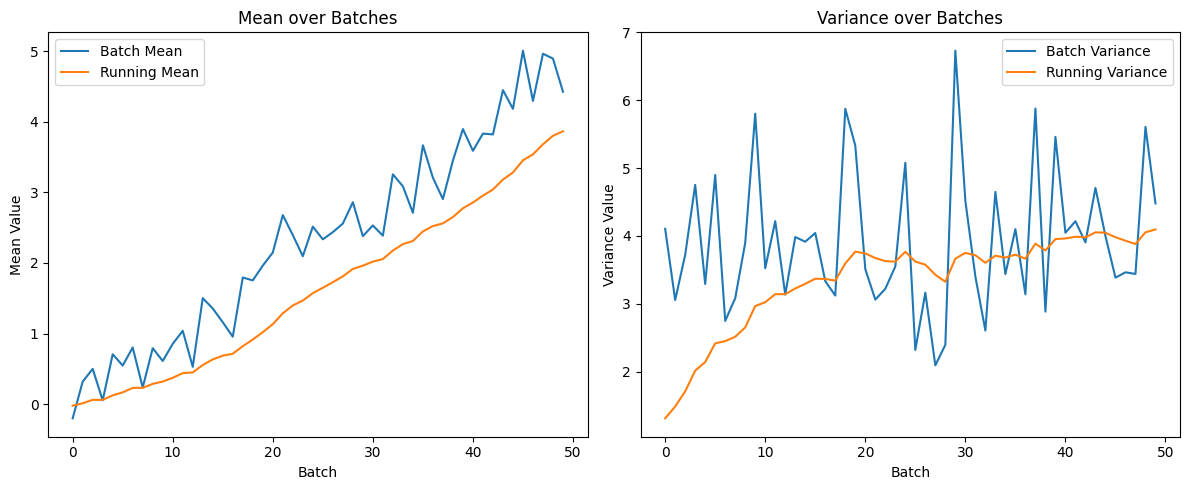

<Figure size 640x480 with 0 Axes>

In [10]:
# Visualize batch vs running stats
plt.figure(figsize=(12, 5))

# Mean Tracking
plt.subplot(1, 2, 1)
plt.plot(batch_means, label='Batch Mean')
plt.plot(running_means, label='Running Mean')
plt.title('Mean over Batches')
plt.xlabel('Batch')
plt.ylabel('Mean Value')
plt.legend()

# Variance Tracking
plt.subplot(1, 2, 2)
plt.plot(batch_vars, label='Batch Variance')
plt.plot(running_vars, label='Running Variance')
plt.title('Variance over Batches')
plt.xlabel('Batch')
plt.ylabel('Variance Value')
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('batch_norm_stats.png', dpi=300)


💬 Explanation:

Left plot: Tracks how the batch mean fluctuates vs. how the running mean smooths over time.

Right plot: Same for variance.

This demonstrates exactly how momentum in BatchNorm helps stabilize inference.